# The script compares the output variables from standard Opensim offline workflow with the ones from the realtime calculations. This is done mainly by plotting ensemble curves and performing statistical analysis

In [115]:
%matplotlib inline
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
import os
import sys
sys.path.insert(0, os.path.abspath('D:\LocalDisk\Research\Opensim\RealTime\Scripts'))
import readMotionFile

os.chdir('D:\LocalDisk\Research\Opensim\RealTime\\results_rt\\results_rt\\')
os.getcwd()

'D:\\LocalDisk\\Research\\Opensim\\RealTime\\results_rt\\results_rt'

## Load the variables from real time
**Import the csv file of the filtered joint angles (ja_rt)**

In [116]:
ja_rt = pd.read_csv('q_filtered.csv')

Capture the knee flexion angle and transform it in degrees

In [117]:
data_rad = ja_rt['knee_angle_r']
time = ja_rt['time']
print(time)
data_degrees = (data_rad*180)/np.pi

0       0.90
1       0.96
2       1.02
3       1.09
4       1.15
5       1.20
6       1.23
7       1.27
8       1.31
9       1.35
10      1.39
11      1.45
12      1.52
13      1.57
14      1.63
15      1.73
16      1.79
17      1.84
18      1.88
19      1.91
20      1.95
21      1.99
22      2.05
23      2.10
24      2.22
25      2.33
26      2.37
27      2.40
28      2.44
29      2.47
       ...  
146     8.73
147     8.77
148     8.80
149     8.83
150     8.86
151     8.91
152     8.96
153     9.12
154     9.34
155     9.40
156     9.43
157     9.46
158     9.51
159     9.55
160     9.60
161     9.65
162     9.72
163     9.81
164     9.87
165     9.92
166     9.95
167     9.99
168    10.02
169    10.06
170    10.11
171    10.17
172    10.23
173    10.28
174    10.35
175    10.43
Name: time, dtype: float64


Plot the knee angle as degrees

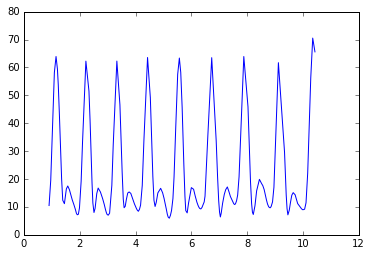

In [118]:
plt.plot(time,data_degrees*-1)

**Now load the joint moments (jm_rt)**

In [119]:
jm_rt = pd.read_csv('tau.csv')


Plot the knee moment

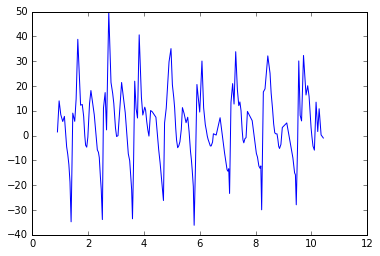

In [120]:
plt.plot(time,jm_rt.knee_angle_r)


Load the static optimization force results (sof) and plot the glut_med force

In [121]:
sof = pd.read_csv('so.csv')

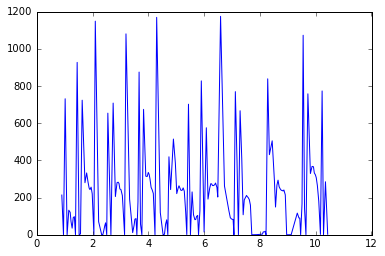

In [122]:
plt.plot(time,sof.glut_med1_r)

Load the joint reaction forces (jrf) results (sof) and plot the vertical hip contact force

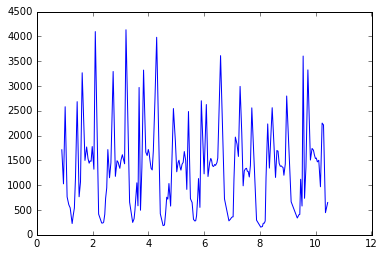

In [123]:
jrf = pd.read_csv('jr.csv')
plt.plot(time,jrf.hip_r_on_femur_r_in_ground_fy*-1)

# Now we load the offline data

In [129]:
path = 'D:\LocalDisk\PHD\Matlab_Output_files\Esther\Esther\Treadmill\Hamn_new\Results'
header, labels, data = readMotionFile.read(path + '\KS\TR_3_IK_Esther.mot')
index = labels.index('knee_angle_r')
data = array(data)
time = data[:,0]
print(time)

[  0.00000000e+00   1.00000000e-02   2.00000000e-02 ...,   1.05700000e+01
   1.05800000e+01   1.05900000e+01]


Plot the knee angle

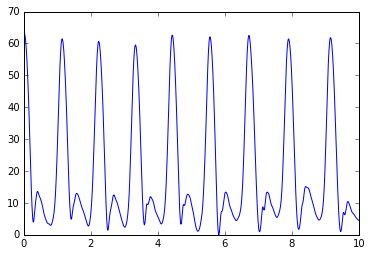

In [125]:
plt.plot(time,data[:,index]*-1)

In [131]:
header, labels, data = readMotionFile.read(path + '\ID\TR_3_ID_Esther.sto')
index = labels.index('knee_angle_r_moment')
data = array(data)
time = data[:,0]

Plot the knee moment arm

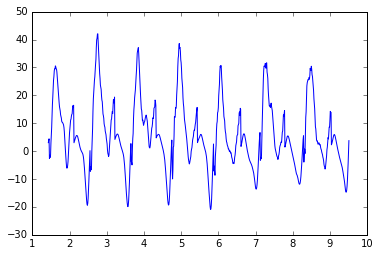

In [132]:
plt.plot(time,data[:,index])